# Lab5 - Training Deep Convolutional Neural Network
Name1, Student's ID1

Name2, Student's ID2

Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction 

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use Fasion MNIST 
See http://yann.lecun.com/exdb/mnist <br>
See http://cs231n.github.io/convolutional-networks/?fbclid=IwAR0durlDroPirYKi0UIpZ9WPETMvNOvavvvD20CqYnFgNGX5ELRqlMwKjOA <br>
See https://www.kaggle.com/moghazy/guide-to-cnns-with-data-augmentation-keras?fbclid=IwAR1hmyCRj_eQHBO9U8hfihF1P7KOmzFCiRfxRiW-DOfxpMZpxD6xxdS642w <br>
See https://www.kaggle.com/c/dogs-vs-cats/data
### Answer this Question for this training lab ::
5.5 Compare the result
Compare the result between a model with data augmentation and without data augmentation
6.1 What do you think the network can detect?

In [0]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.layers.convolutional import  MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

### 1. Load Fasion MNIST dataset 

In [0]:
### Load dataset ###

####################

###Label	Class
###0	T-shirt/top
###1	Trouser
###2	Pullover
###3	Dress
###4	Coat
###5	Sandal
###6	Shirt
###7	Sneaker
###8	Bag
###9	Ankle boot

In [2]:
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [4]:
len(test_labels)

10000

In [0]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

### 2. Preprocess data 

In [0]:
train_images = train_images.reshape(train_images .shape[0], 28, 28 , 1).astype('float32') # Reshape

test_images = test_images.reshape(test_images.shape[0], 28, 28 , 1).astype('float32') # Reshape



In [0]:
train_labels = np_utils.to_categorical(train_labels)
test_labels = np_utils.to_categorical(test_labels)

In [7]:
train_images.shape

(60000, 28, 28, 1)

In [8]:
784/9

87.11111111111111

### 3. Build a convolutional neural network 
Try to build a network that have a same or out perform our previous fully-connect model. (You can use any technique)

In [9]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(40, kernel_size=5, padding="same",input_shape=(28, 28, 1), activation = 'relu',name ='conv1_1'))
cnn.add(layers.MaxPool2D((2, 2)))
cnn.add(layers.Dropout(0.25))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Dropout(0.25))
cnn.add(layers.Dense(10, activation='softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(40, kernel_size=5, padding="same",input_shape=(28, 28, 1), activation = 'relu',name ='conv1_1'))
cnn.add(layers.MaxPool2D((2, 2)))
cnn.add(layers.Dropout(0.25))
cnn.add(layers.Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',name ='conv1_2'))
cnn.add(layers.MaxPool2D((2, 2)))
cnn.add(layers.Dropout(0.25))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Dropout(0.25))
cnn.add(layers.Dense(10, activation='softmax'))

In [0]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 28, 28, 40)        1040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 40)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 40)        0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 12, 12, 32)        11552     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

In [10]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 4. Trainig CNN Model 

In [0]:
### Split train and validation data ###

####################################### 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( train_images,train_labels, test_size=0.1, random_state=1,stratify=train_labels)
### Split data ###

##################

In [12]:
### Train model ###

###################
his = cnn.fit(x_train,y_train,epochs=10,batch_size=128,validation_data=(x_test,y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 54000 samples, validate on 6000 samples
Epoch 1/10





54000/54000 [==============================] - 13s 245us/step - loss: 0.4511 - acc: 0.8459 - val_loss: 0.3244 - val_acc: 0.8847
Epoch 2/10
54000/54000 [==============================] - 5s 98us/step - loss: 0.3111 - acc: 0.8908 - val_loss: 0.2908 - val_acc: 0.8953
Epoch 3/10
54000/54000 [==============================] - 5s 97us/step - loss: 0.2683 - acc: 0.9034 - val_loss: 0.2807 - val_acc: 0.9008
Epoch 4/10
54000/54000 [==============================] - 5s 98us/step - loss: 0.2453 - acc: 0.9115 - val_loss: 0.2679 - val_acc: 0.9045
Epoch 5/10
54000/54000 [==============================] - 5s 97us/step - loss: 0.2296 - acc: 0.9171 - val_loss: 0.2849 - val_acc: 0.8990
Epoch 6/10
54000/54000 [==============================] - 5s 98us/step - loss: 0.2149 - acc: 0.9216 - val_loss: 0.2426 - val_acc: 0.9137
Epoch 7/10
54000/54000 [=

Last train accuracy: 0.9357407407054195
Last validation accuracy: 0.9153333328564962


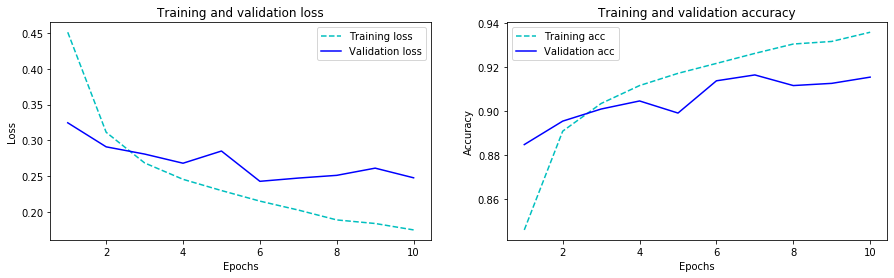

In [17]:
show_result(his)

### 5. Evaluate your model 
#### 5.1 Show the confusion matrix and classification report
Using function ```evaluation_report(model,feature,label)``` define above to print the classification report

In [18]:
test_loss, test_acc = cnn.evaluate(x_test,y_test)
print('Test Loss: %s\nTest Accuracy: %s' % (test_loss,test_acc))

6000/6000 [==============================] - 1s 86us/step
Test Loss: 0.24748273784915606
Test Accuracy: 0.9153333333333333


In [0]:
pred_class = cnn.predict(test_images).argmax(axis=1)

In [28]:
pred_class[100]

3

In [24]:
len(pred_class)
labels = test_labels.argmax(axis=1)

10000

In [29]:
labels[100]

3

In [25]:
len(labels)

10000

In [0]:
pred_class = evaluation_report(cnn,test_images,test_labels)

[[878   0  14  21   3   1  79   0   4   0]
 [  0 980   0  13   2   0   3   0   2   0]
 [ 14   0 858  10  69   0  49   0   0   0]
 [ 10   0   9 924  24   0  33   0   0   0]
 [  0   0  63  25 856   0  56   0   0   0]
 [  0   0   0   0   0 982   0  11   0   7]
 [130   1  63  30  84   0 688   0   4   0]
 [  0   0   0   0   0   7   0 976   0  17]
 [  2   0   6   4   4   1   4   1 978   0]
 [  0   0   0   0   0   5   0  29   0 966]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1000
           1       1.00      0.98      0.99      1000
           2       0.85      0.86      0.85      1000
           3       0.90      0.92      0.91      1000
           4       0.82      0.86      0.84      1000
           5       0.99      0.98      0.98      1000
           6       0.75      0.69      0.72      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.98      0.98      1000
           9       0.98     

### 6.2 Show which image that your model incorrectly predict

Using function ```show_false_prediction(pred_class, actual_feature, actual_label)``` that is define above to show which image that your model predict wrong.

In [0]:
###Label	Class
###0	T-shirt/top
###1	Trouser
###2	Pullover
###3	Dress
###4	Coat
###5	Sandal
###6	Shirt
###7	Sneaker
###8	Bag
###9	Ankle boot

(914, 28, 28)


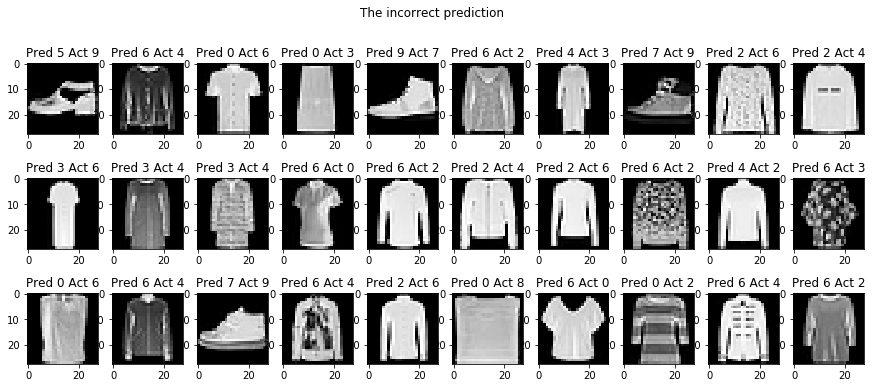

In [0]:
show_false_prediction(pred_class,test_images,test_labels.argmax(axis=1))

### 5. Data Augmentation 

Using the ```ImageDataGenerator``` module to generate more data. This technique is called data augmentation. It help generate more variation of the data which help prevent overfit and generalize better.

Lookup in the Keras document to see what method does it provide. https://keras.io/preprocessing/image

Becasue we want to build a data generator object, we have to re-load the data and specify rescale argument in ImageDataGenerator module.

In [0]:
# Re-load the image data
(X_train,y_train), (X_test,y_test) =  fashion_mnist.load_data()

# Because the ImageDataGenerator require tensor of 4 dimension 
# Reshape data to 4 dimension (batch, width, height, channel)
def reshape_gray(data):
    data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
    return data

X_train = reshape_gray(X_train)
X_test = reshape_gray(X_test)

# split to validation set and train set
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=0,stratify=y_train)

In [0]:
y_train= np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=0,stratify=y_train)

In [0]:
# update global variable
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]

BATCH_SIZE = 32

In [0]:
#y_train = to_categorical(y_train)
#y_val = to_categorical(y_val)

In [0]:
# Define a generator for train set and test set

train_datagen = image.ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=False)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [0]:
# Create an Iterator object. 
train_generator = train_datagen.flow(X_train,y_train,
                                    batch_size = BATCH_SIZE,
                                    seed=0)

validate_generator = test_datagen.flow(X_val,y_val,
                                    batch_size = BATCH_SIZE,
                                    shuffle=False)

#### 5.2 Initialize new model using same network structure 

In [0]:
cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(40, kernel_size=5, padding="same",input_shape=(28,28,1), activation = 'relu',name ='conv2_1'))
cnn2.add(layers.MaxPool2D((2, 2)))
cnn2.add(layers.Dropout(0.25))
cnn2.add(layers.Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',name ='conv2_2'))
cnn2.add(layers.MaxPool2D((2, 2)))
cnn2.add(layers.Dropout(0.25))
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(64, activation='relu'))
cnn2.add(layers.BatchNormalization())
cnn2.add(layers.Dropout(0.25))
cnn2.add(layers.Dense(10, activation='softmax'))


In [0]:
cnn2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### 5.3 Train a model using Data Augmentation

In [0]:
# Using fit_generator to train your model. We don't need to specify the batch size since we already done that when we create Iterator
his2 = cnn2.fit_generator(train_generator, 
                              epochs=20, 
                              validation_data=validate_generator)

Epoch 1/20
1688/1688 [==============================] - 34s 20ms/step - loss: 1.1831 - acc: 0.5694 - val_loss: 0.7525 - val_acc: 0.7012
Epoch 2/20
1688/1688 [==============================] - 33s 19ms/step - loss: 0.8783 - acc: 0.6753 - val_loss: 0.7276 - val_acc: 0.7142
Epoch 3/20
1688/1688 [==============================] - 33s 19ms/step - loss: 0.8206 - acc: 0.6938 - val_loss: 0.6093 - val_acc: 0.7565
Epoch 4/20
1688/1688 [==============================] - 32s 19ms/step - loss: 0.7839 - acc: 0.7080 - val_loss: 0.5584 - val_acc: 0.7770
Epoch 5/20
1688/1688 [==============================] - 32s 19ms/step - loss: 0.7590 - acc: 0.7185 - val_loss: 0.5239 - val_acc: 0.7962
Epoch 6/20
1688/1688 [==============================] - 32s 19ms/step - loss: 0.7290 - acc: 0.7304 - val_loss: 0.5095 - val_acc: 0.7937
Epoch 7/20
1688/1688 [==============================] - 32s 19ms/step - loss: 0.7173 - acc: 0.7328 - val_loss: 0.4945 - val_acc: 0.8050
Epoch 8/20
1688/1688 [==========================

# 5.4 Evaluate your model

Last train accuracy: 0.9430740740740741
Last validation accuracy: 0.9861666666666666


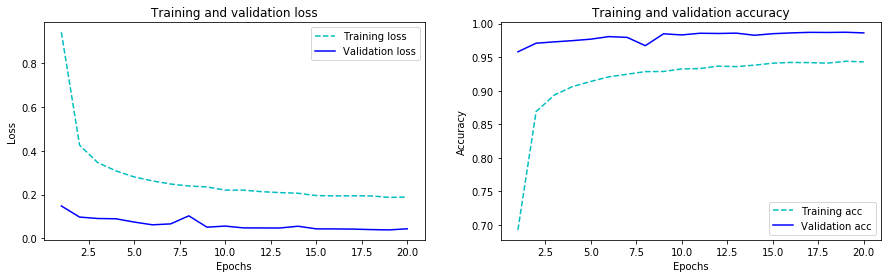

In [0]:
show_result(his2)

#### 5.5 Compare the result

Compare the result between a model with data augmentation and without data augmentation

### 6. Visualize Layer Activation 
**Note:** the function is defined above.

In [0]:
# Create an activation model (the model with convolution layer only)

num_conv = 4# Number of convolutional layer in your model (if more than 4, just used 4)
layer_outputs = [layer.output for layer in cnn.layers[:num_conv]]
activation_model = models.Model(inputs=cnn.input, outputs=layer_outputs)
activation_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 28, 28, 40)        1040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 40)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 40)        0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 12, 12, 32)        11552     
Total params: 12,592
Trainable params: 12,592
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.preprocessing import image

# load image to feed into network
img = image.load_img('/content/test.PNG',target_size=(28,28),grayscale=True)
img_tensor = image.img_to_array(img)

# Preprocess data
img_tensor = np.expand_dims(image.img_to_array(img),axis=0)/255.

# Feed into activation model to get an activation value
activation = activation_model.predict(img_tensor)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


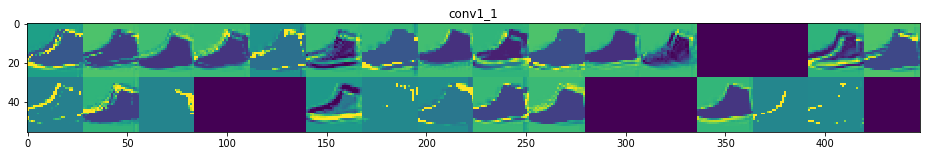

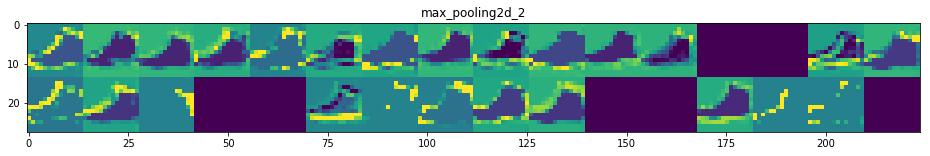

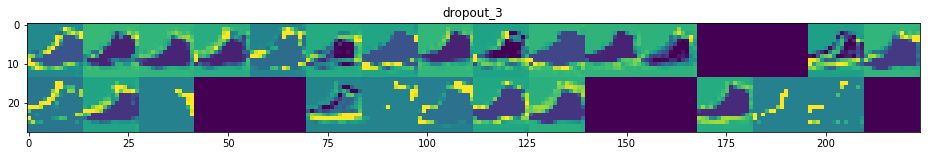

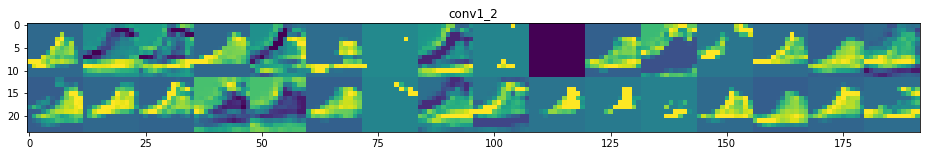

In [0]:
### Feed your model and number of layer you want to show 

show_layer_activation(activation,cnn,5)

#### 6.1 What do you think the network can detect?

### 8. Transfer Learning 
- What is transfer learning https://towardsdatascience.com/transfer-learning-946518f95666
- which transfer learning method to use https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

The following is a tutorial code to load and freeze some layer. Keras also come with a build-in pre-train network on imageNet dataset (See www.image-net.org)

Keras Pre-train Network https://keras.io/applications

#### 8.1.1 Use Build-in Pre-train Network
Keras come with a build-in pre-train network that let you download and use it in your problem. You can import only model structure or import neuron weight that had been train on imageNet.

In [0]:
from keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False, 
                  weights='imagenet',
                  input_shape=(150,150,3))

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### 8.1.2 Use Our Pre-train Network

When we are doing the deep learning/machine learning project, sometime, we may encounter a similar problem. After several project, we will have many existing model that we experiment and develop. We can used these model as a pre-train network to solve a new problem. This can save a hugh cost (time and money) and jump start our new project very quickly.

In [0]:
cnn.save('cnn.h5')

In [0]:
prev_cnn = models.load_model('cnn.h5')
prev_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 28, 28, 40)        1040      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 40)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 40)        0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 12, 12, 32)        11552     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [0]:
# Use .pop() to remove the last layer
# In this case, we want to remove last two layer

prev_cnn.pop()
prev_cnn.pop()

In [0]:
# See how our model change
prev_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 28, 28, 40)        1040      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 40)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 40)        0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 12, 12, 32)        11552     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


For both method, if you want to change input size of your network, you have to create a model using functional API.
See https://keras.io/models/model

#### 8.2.1 Freezing layer - All

In [0]:
# If we don't want to train these layer, we have to freeze these layer. 
# Note that if we want a pre-train as a weight initializer, we don't have to freeze the layer.

prev_cnn.trainable = False

#### 8.2.2 Freezing layer - Specific layer

In [0]:
# Freeze a specific layers
# Freeze first 3 layer
for i in range(3):
    prev_cnn.layers[i].trainable = False

#### 8.3 Connnect your model

In [0]:
# Time to create a new model
new_cnn = models.Sequential()

# Add convolutional layer as a pre-train network
new_cnn.add(prev_cnn)

# Define fully-connect layer
new_cnn.add(layers.Dense(256,activation='elu'))
new_cnn.add(layers.Dropout(0.2))
new_cnn.add(layers.Dense(10,activation='softmax',name='output'))

# Show how your network looklike
new_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 64)                86640     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 105,850
Trainable params: 19,210
Non-trainable params: 86,640
_________________________________________________________________


After this process, you can use your network as the way you like. 